In [1]:
import sys
sys.path.insert(0,"../")
import time

import numpy as np
from matplotlib import pyplot as plt
from IPython.display import clear_output

from src.optimizers.neioptimizer import *
from src.utils.config import CONFIG
CONFIG

{'distribute': {'computer_list': ['tst008@acet116-lnx-10.bucknell.edu',
   'tst008@acet116-lnx-11.bucknell.edu',
   'tst008@acet116-lnx-12.bucknell.edu'],
  'max_jobs': 1,
  'min_gpu': 500},
 'optimizer': {'num_restarts': 10,
  'raw_samples': 500,
  'options': {'batch_limit': 5, 'max_iter': 200, 'seed': 0}}}

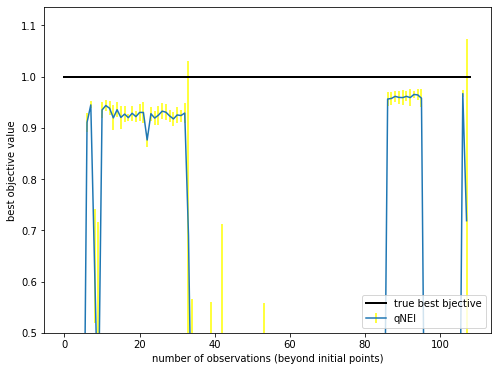

In [422]:
from botorch.test_functions.synthetic import Hartmann


FILE_NAME = "../yaleface_first.json"


def visualize():
    # Load the data
    train_obj_nei, train_yvar_nei = [], []
    with open(FILE_NAME, "r") as f:
        for line in f.readlines():
            observation = json.loads(line)
            train_obj_nei.append(observation["result"][0])
            train_yvar_nei.append(np.sqrt(observation["result"][1]))

#     neg_hartmann6 = Hartmann(negate=True)
#     GLOBAL_MAXIMUM = neg_hartmann6.optimal_value
    GLOBAL_MAXIMUM = 1

    iters = np.arange(max(len(train_obj_nei), len(train_obj_nei)))
    y_nei = np.array(train_obj_nei)
    y_err = np.array(train_yvar_nei)

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.errorbar(iters, y_nei, yerr=y_err, label="qNEI", linewidth=1.5, ecolor=['yellow'])
    plt.plot([0, iters.shape[0]], [GLOBAL_MAXIMUM] * 2, 'k', label="true best bjective", linewidth=2)
    ax.set_ylim(bottom=0.5)
    ax.set(xlabel='number of observations (beyond initial points)', ylabel='best objective value')
    ax.legend(loc="lower right")
    plt.show()

count = 199
while count < 200:
    visualize()
    clear_output(wait=True)
    time.sleep(2)
    count += 1

# -------------- DRAFT --------------

In [508]:
torch.rand(1,1,1,1).item()

0.49500226974487305

In [ ]:
datetime.datetime.now().strftime("%m/%d/%Y-%H:%M:%S")

In [288]:
from botorch.utils.transforms import (
    match_batch_shape
)
X = torch.rand((1,1,6))
X, X.shape

(tensor([[[0.0434, 0.3694, 0.9811, 0.5450, 0.7956, 0.7019]]]),
 torch.Size([1, 1, 6]))

In [289]:
X.shape, match_batch_shape(X, torch.tensor([])).shape

(torch.Size([1, 1, 6]), torch.Size([1, 1, 1, 6]))

In [290]:
torch.cat([X, match_batch_shape(X, torch.tensor([]))], dim=-2)

RuntimeError: invalid argument 0: Tensors must have same number of dimensions: got 3 and 4 at /pytorch/aten/src/TH/generic/THTensor.cpp:603

In [444]:
from botorch import fit_gpytorch_model
from botorch.models import HeteroskedasticSingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
import torch

train_X = torch.rand(1, 1, 2)
train_Y = torch.sin(train_X).sum(dim=-1, keepdim=True)
se = torch.norm(train_X, dim=-1, keepdim=True)
train_Yvar = 0.1 + se * torch.rand_like(train_Y)
model = HeteroskedasticSingleTaskGP(train_X, train_Y, train_Yvar).to(train_X)
mll = ExactMarginalLogLikelihood(model.likelihood, model)
fit_gpytorch_model(mll);

In [409]:
from abc import ABC, abstractmethod
from typing import Optional

import torch
from botorch.exceptions import UnsupportedError
from botorch.posteriors import Posterior
from botorch.sampling import MCSampler
from botorch.utils.sampling import draw_sobol_normal_samples, manual_seed
from torch import Tensor
from torch.nn import Module
from torch.quasirandom import SobolEngine


class SobolQMCNormalSampler(MCSampler):
    r"""Sampler for quasi-MC base samples using Sobol sequences.

    Example:
        >>> sampler = SobolQMCNormalSampler(1000, seed=1234)
        >>> posterior = model.posterior(test_X)
        >>> samples = sampler(posterior)
    """

    def __init__(
        self,
        num_samples: int,
        resample: bool = False,
        seed: Optional[int] = None,
        collapse_batch_dims: bool = True,
    ) -> None:
        r"""Sampler for quasi-MC base samples using Sobol sequences.

        Args:
            num_samples: The number of samples to use.
            resample: If `True`, re-draw samples in each `forward` evaluation -
                this results in stochastic acquisition functions (and thus should
                not be used with deterministic optimization algorithms).
            seed: The seed for the RNG. If omitted, use a random seed.
            collapse_batch_dims: If True, collapse the t-batch dimensions to
                size 1. This is useful for preventing sampling variance across
                t-batches.
        """
        super().__init__()
        self._sample_shape = torch.Size([num_samples])
        self.collapse_batch_dims = collapse_batch_dims
        self.resample = resample
        self.seed = seed if seed is not None else torch.randint(0, 1000000, (1,)).item()

    def _construct_base_samples(self, posterior: Posterior, shape: torch.Size) -> None:
        r"""Generate quasi-random Normal base samples (if necessary).

        This function will generate a new set of base samples and set the
        `base_samples` buffer if one of the following is true:

        - `resample=True`
        - the MCSampler has no `base_samples` attribute.
        - `shape` is different than `self.base_samples.shape` (if
          `collapse_batch_dims=True`, then batch dimensions of will be
          automatically broadcasted as necessary)

        Args:
            posterior: The Posterior for which to generate base samples.
            shape: The shape of the base samples to construct.
        """
        if (
            self.resample
            or not hasattr(self, "base_samples")
            or self.base_samples.shape[-2:] != shape[-2:]
            or (not self.collapse_batch_dims and shape != self.base_samples.shape)
        ):
            output_dim = shape[-2:].numel()
            if output_dim > SobolEngine.MAXDIM:
                raise UnsupportedError(
                    "SobolQMCSampler only supports dimensions "
                    f"`q * o <= {SobolEngine.MAXDIM}`. Requested: {output_dim}"
                )
            base_samples = draw_sobol_normal_samples(
                d=output_dim,
                n=shape[:-2].numel(),
                device=posterior.device,
                dtype=posterior.dtype,
                seed=self.seed,
            )
            print(base_samples)
            print(shape)
            self.seed += 1
            base_samples = base_samples.view(shape)
            self.register_buffer("base_samples", base_samples)
        elif self.collapse_batch_dims and shape != posterior.event_shape:
            self.base_samples = self.base_samples.view(shape)
        if self.base_samples.device != posterior.device:
            self.to(device=posterior.device)  # pragma: nocover
        if self.base_samples.dtype != posterior.dtype:
            self.to(dtype=posterior.dtype)

In [457]:
candidate = torch.tensor([0.1, 0.2]).view(-1, 1,2)
torch.cat([train_X, candidate])

tensor([[[0.4524, 0.8685]],

        [[0.1000, 0.2000]]])

In [496]:
train_Yvar

tensor([[[0.3447]]])

In [491]:
p = model.posterior(torch.cat([train_X]))

In [504]:
p.mvn.enumerate_support

<bound method Distribution.enumerate_support of MultivariateNormal(loc: tensor([[1.2006]], grad_fn=<ViewBackward>), covariance_matrix: tensor([[[0.2736]]], grad_fn=<AddBackward0>), precision_matrix: tensor([[[3.6550]]], grad_fn=<ExpandBackward>), scale_tril: tensor([[[0.5231]]], grad_fn=<ExpandBackward>))>

In [472]:
s = SobolQMCNormalSampler(1)
s(p)

tensor([[-0.5362]])
torch.Size([1, 1, 1, 1])


tensor([[[[0.9202]]]], grad_fn=<UnsqueezeBackward0>)

In [468]:
model.posterior(train_X.view(-1, 2))\
    .sample(
        base_samples=torch.tensor([0.1, 0.2]).view(-1, 2)
)

RuntimeError: The expanded size of the tensor (1) must match the existing size (2) at non-singleton dimension 3.  Target sizes: [1, 1, 1, 1].  Tensor sizes: [1, 2]

In [424]:
with torch.no_grad():
    shape = model.posterior(train_X.view(-1, 2)).mvn.event_shape
shape

torch.Size([20])